Research Paper: https://arxiv.org/abs/1503.02531

This is the foundational paper that introduced the idea of knowledge distillation

Dataset: MNIST


Code Link:
1. https://github.com/tripdancer0916/keras-knowledge-distillation/tree/master
1. https://github.com/poperson1205/knowledge_distillation

Training the student not only to predict the correct labels but also to mimic the soft probabilities of the teacher. These soft probabilities, often computed with a high temperature in the softmax, carry richer information than one-hot hard labels.

In [3]:
!pip install torch torchvision --quiet


In [25]:
# import libaraies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights

In [5]:
# Load Data - CIFAR10
mean = [0.4914, 0.4822, 0.4465]
std = [0.2471, 0.2435, 0.2616]


train_transform = transforms.Compose([transforms.Pad(4),
                                      transforms.RandomCrop(32),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean, std=std)])

test_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:12<00:00, 13265548.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
# transform = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# ])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


In [47]:
################ INPUT ################
lr_input = 0.1
momentum_input = 0.9
weight_decay_input = 5e-4
epochs = 20
T = 4.0 # temperatureture
alpha = 0.9
patience = 5  # for early stopping
#######################################

In [48]:
# # define the Teacher and Student models
# teacher = torchvision.models.resnet34(pretrained=True).cuda()
# student = torchvision.models.resnet18(pretrained=False).cuda()

# # define the loss function and optimizers
# criterion = nn.CrossEntropyLoss()
# teacher_optimizer = optim.SGD(teacher.parameters(), lr=lr_input, momentum=momentum_input, weight_decay=weight_decay_input)
# student_optimizer = optim.SGD(student.parameters(), lr=lr_input, momentum=momentum_input, weight_decay=weight_decay_input)

The warnings above are due to recent changes in the torchvision library. They have started transitioning from using the pretrained argument to the weights argument to specify the desired weights when creating a model.

In [56]:
# Define teacher and student model
teacher = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
student = torchvision.models.resnet18(weights=None).cuda()

# teacher = torchvision.models.resnet34(pretrained=True).cuda()
# student = torchvision.models.resnet18(pretrained=False).cuda()

# define the loss function and optimizers
criterion = nn.CrossEntropyLoss()
# Note: You were re-assigning the optimizer variable. I assume you wanted two separate optimizers.
teacher_optimizer = optim.SGD(teacher.parameters(), lr=lr_input, momentum=momentum_input, weight_decay=weight_decay_input)
student_optimizer = optim.SGD(student.parameters(), lr=lr_input, momentum=momentum_input, weight_decay=weight_decay_input)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


In [57]:
# Train the teacher model
for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.cuda(), labels.cuda()
        teacher_optimizer.zero_grad()
        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        teacher_optimizer.step()

In [58]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    return total_loss / len(loader), accuracy, precision, recall, f1

In [59]:
def train_epoch(loader, student, teacher, optimizer, criterion, temperature=1, alpha=0.5):
    student.train()
    teacher.eval()

    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    for inputs, labels in loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass for the student and teacher networks
        student_outputs = student(inputs)
        with torch.no_grad():
            teacher_outputs = teacher(inputs)

        # Compute the knowledge distillation loss
        KD_loss = nn.KLDivLoss()(F.log_softmax(student_outputs/temperature, dim=1),
                                 F.softmax(teacher_outputs/temperature, dim=1))

        # Compute the usual classification loss
        CL_loss = criterion(student_outputs, labels)

        # Total loss is a weighted sum of the KD loss and classification loss
        loss = alpha * KD_loss + (1 - alpha) * CL_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = student_outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

    # Compute metrics for this epoch
    accuracy = 100 * correct / total
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=1)
    f1 = f1_score(all_targets, all_preds, average='macro')

    return total_loss / len(loader), accuracy, precision, recall, f1


In [60]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []

print("Starting Knowledge Distillation...")

best_loss = float('inf')
stop_counter = 0  # Counter for early stopping


for epoch in range(epochs):
    # Training
    train_loss, train_accuracy, train_precision, train_recall, train_f1 = \
        train_epoch(train_loader, student, teacher, student_optimizer, criterion, temperature=T, alpha=alpha)
    # Evaluation
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(student, test_loader)

    # Update learning rate
    scheduler.step(test_loss)
    # Check for early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        stop_counter = 0
    else:
        stop_counter += 1
        if stop_counter >= patience:
            print("Early stopping!")
            break

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_precisions.append(train_precision)
    test_precisions.append(test_precision)
    train_recalls.append(train_recall)
    test_recalls.append(test_recall)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    print(f"[Epoch {epoch+1}] Training: Loss: {train_loss}, Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1: {train_f1}")
    print(f"[Epoch {epoch+1}] Testing: Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}")

print("Finished Knowledge Distillation.")

Starting Knowledge Distillation...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch p

[Epoch 1] Training: Loss: 0.17314488086325433, Accuracy: 38.446, Precision: 0.04479946023789899, Recall: 0.9275835294117647, F1: 0.04490509798485415
[Epoch 1] Testing: Loss: 1.4204928035948687, Accuracy: 48.56, Precision: 0.5109188223083236, Recall: 0.4856000000000001, F1: 0.47854997798470117


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Epoch 2] Training: Loss: 0.13182085283729425, Accuracy: 52.87, Precision: 0.5251581845390951, Recall: 0.5287000000000001, F1: 0.526565582104649
[Epoch 2] Testing: Loss: 1.1642739343795048, Accuracy: 58.25, Precision: 0.6086689200303056, Recall: 0.5825, F1: 0.5768663063598396


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Epoch 3] Training: Loss: 0.11636288444061413, Accuracy: 58.934, Precision: 0.5870096846181532, Recall: 0.58934, F1: 0.5879807556508714
[Epoch 3] Testing: Loss: 1.1234724316627356, Accuracy: 61.66, Precision: 0.6496976322765388, Recall: 0.6166, F1: 0.6207517447931292


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Epoch 4] Training: Loss: 0.10835865668742858, Accuracy: 62.424, Precision: 0.6220265974003142, Recall: 0.62424, F1: 0.6229705500072044
[Epoch 4] Testing: Loss: 1.025359215630088, Accuracy: 64.44, Precision: 0.6636364136231379, Recall: 0.6444, F1: 0.6416396421362103


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Epoch 5] Training: Loss: 0.10324949956953983, Accuracy: 64.506, Precision: 0.6429283451880716, Recall: 0.64506, F1: 0.6438035494867645
[Epoch 5] Testing: Loss: 1.0778960133813749, Accuracy: 63.71, Precision: 0.6560979029542422, Recall: 0.6371, F1: 0.6308210647964547


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Epoch 6] Training: Loss: 0.09962101114432678, Accuracy: 65.842, Precision: 0.6567360143936968, Recall: 0.65842, F1: 0.6574242782432556
[Epoch 6] Testing: Loss: 1.1156926128515012, Accuracy: 63.36, Precision: 0.6843787820739642, Recall: 0.6336, F1: 0.6322702713863868


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Epoch 7] Training: Loss: 0.09641322657904204, Accuracy: 67.038, Precision: 0.6687801304945183, Recall: 0.67038, F1: 0.66941652497598
[Epoch 7] Testing: Loss: 0.9689543353524178, Accuracy: 66.38, Precision: 0.6949382941272388, Recall: 0.6638000000000001, F1: 0.6623078878831954


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Epoch 8] Training: Loss: 0.09460281394898434, Accuracy: 67.708, Precision: 0.6755648483199056, Recall: 0.6770799999999999, F1: 0.676178645750384
[Epoch 8] Testing: Loss: 0.9138754017793449, Accuracy: 68.94, Precision: 0.7038305682563197, Recall: 0.6894, F1: 0.6892618949415219


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Epoch 9] Training: Loss: 0.092320226480627, Accuracy: 68.494, Precision: 0.6838388424753161, Recall: 0.68494, F1: 0.684239077212966
[Epoch 9] Testing: Loss: 0.8641431305059202, Accuracy: 70.43, Precision: 0.7142568964333706, Recall: 0.7043, F1: 0.699273972635819


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Epoch 10] Training: Loss: 0.09156007984715045, Accuracy: 68.908, Precision: 0.6875327463180578, Recall: 0.6890799999999999, F1: 0.6882151674634539
[Epoch 10] Testing: Loss: 0.9656176544298791, Accuracy: 67.16, Precision: 0.6927164460273383, Recall: 0.6716, F1: 0.6729373773237626


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Epoch 11] Training: Loss: 0.08915206389334958, Accuracy: 69.61, Precision: 0.6946849374891252, Recall: 0.6961, F1: 0.6952563259738389
[Epoch 11] Testing: Loss: 1.033213364850184, Accuracy: 64.52, Precision: 0.6945807787153104, Recall: 0.6451999999999999, F1: 0.6340625949232364


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Epoch 12] Training: Loss: 0.08986979024127469, Accuracy: 69.606, Precision: 0.6948577243043108, Recall: 0.69606, F1: 0.6953624085357194
[Epoch 12] Testing: Loss: 0.9246567128949864, Accuracy: 68.38, Precision: 0.7004158640377318, Recall: 0.6838, F1: 0.6791124754867153


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Epoch 13] Training: Loss: 0.08875551901738662, Accuracy: 69.804, Precision: 0.6969750424846084, Recall: 0.69804, F1: 0.6973864999060145
[Epoch 13] Testing: Loss: 1.1357566334639386, Accuracy: 62.84, Precision: 0.7203470693143204, Recall: 0.6284, F1: 0.6375294150179575
Early stopping!
Finished Knowledge Distillation.


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


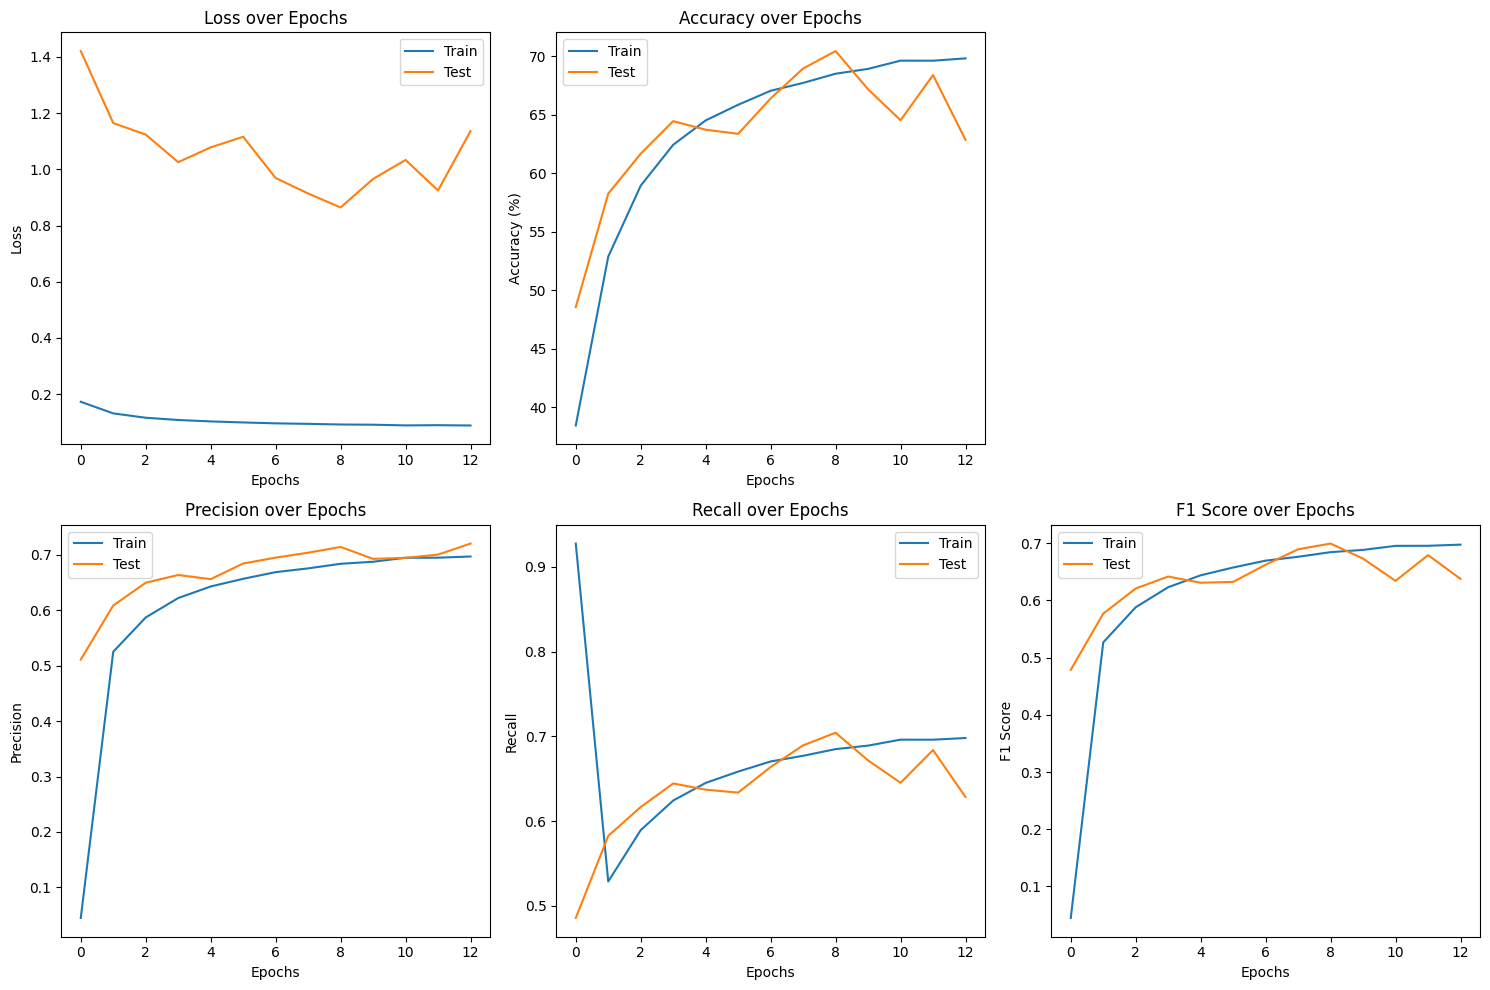

In [61]:
# Plotting
plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting Precision
plt.subplot(2, 3, 4)
plt.plot(train_precisions, label='Train')
plt.plot(test_precisions, label='Test')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plotting Recall
plt.subplot(2, 3, 5)
plt.plot(train_recalls, label='Train')
plt.plot(test_recalls, label='Test')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plotting F1 Score
plt.subplot(2, 3, 6)
plt.plot(train_f1s, label='Train')
plt.plot(test_f1s, label='Test')
plt.title('F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()